In [1]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from tools import get_data_softDrop

In [2]:
class TimeDistributed(nn.Module):
    def __init__(self,module):
        super().__init__()
        self.module = module
        
    def forward(self,x):
        batch,nstep,n_input = x.shape
        x = x.view(batch*nstep,n_input)
        y = self.module(x)
        y = y.view(batch,nstep,y.shape[-1])
        return y
    
class LatentSum(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        y,weight = x[0],x[1]
        return torch.sum(y*weight,dim=1)

class NN(nn.Module):
    def __init__(self,in_dim,out_dim,widths,act=nn.ReLU(),out_act=nn.Sigmoid()):
        super().__init__()
        layers = [nn.Linear(in_dim,widths[0]),
                  act]
        for i in range(1,len(widths)-1):
            layers.append(nn.Linear(widths[i],widths[i+1]))
            layers.append(act)
        layers.append(nn.Linear(widths[-1],out_dim))
        layers.append(out_act)
        self.transform = nn.Sequential(*layers)

    def forward(self,x):
        return self.transform(x)
    
class SpectralNN(nn.Module):
    def __init__(self,in_dim,out_dim,widths,act=nn.ReLU(),out_act=nn.Sigmoid()):
        super().__init__()
        layers = [utils.spectral_norm(nn.Linear(in_dim,widths[0])),act]
        for i in range(1,len(widths)-1):
            layers.append(utils.spectral_norm(nn.Linear(widths[i],widths[i+1])))
            layers.append(act)
        layers.append(utils.spectral_norm(nn.Linear(widths[-1],out_dim)))
        layers.append(out_act)
        self.transform = nn.Sequential(*layers)

    def forward(self,x):
        return self.transform(x)

In [3]:
def distributed_block_constructor(in_dim,out_dim,widths,act=nn.ReLU(),out_act=nn.Sigmoid(),spectral=False):
    if spectral:
        return TimeDistributed(SpectralNN(in_dim,out_dim,widths,act,out_act))
    else:
        return TimeDistributed(NN(in_dim,out_dim,widths,act,out_act))
    
def block_constructor(in_dim,out_dim,widths,act=nn.ReLU(),out_act=nn.Sigmoid(),spectral=False):
    if spectral:
        return SpectralNN(in_dim,out_dim,widths,act,out_act)
    else:
        return NN(in_dim,out_dim,widths,act,out_act)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')

class PFN(nn.Module):
    def __init__(self,in_dim,out_dim,Phi_sizes,F_sizes,Phi_act=nn.ReLU(),F_act=nn.ReLU(),output_act=nn.Sigmoid(),spectral=False):
        super().__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.latent_dim = Phi_sizes[-1]
        self.Phi = distributed_block_constructor(in_dim=in_dim,
                                     out_dim=self.latent_dim,
                                     widths=Phi_sizes[:-1],
                                     act=Phi_act,
                                     out_act=Phi_act)
        self.latent_sum = LatentSum()
        self.F =  block_constructor(in_dim=self.latent_dim,
                                     out_dim=self.out_dim,
                                     widths=F_sizes,
                                     act=F_act,
                                     out_act=output_act,
                                     spectral=spectral)

    
    def forward(self,x):
        weights = (x[:,:,:1]>0).to(torch.float32)
        latent = self.Phi(x)
        latent = latent*weights
        latent = torch.sum(latent,dim=1)
        return self.F(latent)
    
class EFN(PFN):
    def __init__(self,in_dim,out_dim,Phi_sizes,F_sizes,Phi_act=nn.ReLU(),F_act=nn.ReLU(),output_act=nn.Sigmoid(),spectral=False):
        super().__init__(in_dim,out_dim,Phi_sizes,F_sizes,Phi_act=Phi_act,F_act=F_act,output_act=output_act,spectral=spectral)
    
    def forward(self,x):
        x,z = x[:,:,1:], x[:,:,:1]
        weights = z*(z>0).to(torch.float32)
        latent = self.Phi(x)
        latent = self.latent_sum([latent,weights])
        return self.F(latent)

In [4]:
X,Y = get_data_softDrop("h2qq_R0.8_mH500_softDrop.h5")
perm = np.random.permutation(X.shape[0])
X = X[perm]
Y = Y[perm].reshape(-1,1)

nTrain = int(0.5*X.shape[0])
nVal = int(0.1*X.shape[0])

Xtrain = torch.FloatTensor(X[:nTrain]).to(device)
Ytrain = torch.FloatTensor(Y[:nTrain]).to(device)

Xval = torch.FloatTensor(X[nTrain:nTrain+nVal]).to(device)
Yval = torch.FloatTensor(Y[nTrain:nTrain+nVal]).to(device)

Xtest = torch.FloatTensor(X[nTrain+nVal:]).to(device)
Ytest = torch.FloatTensor(Y[nTrain+nVal:]).to(device)

In [5]:
bs = 10000
dataset = TensorDataset(Xtrain,Ytrain)
loader = DataLoader(dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device='cpu'))

Epoch 0, Train loss 0.69729, Val Loss 0.69334
Epoch 1, Train loss 0.69399, Val Loss 0.69317
Epoch 2, Train loss 0.69319, Val Loss 0.69310
Epoch 3, Train loss 0.69317, Val Loss 0.69311
Epoch 4, Train loss 0.69310, Val Loss 0.69303
Epoch 5, Train loss 0.69305, Val Loss 0.69296
Epoch 6, Train loss 0.69299, Val Loss 0.69289
Epoch 7, Train loss 0.69297, Val Loss 0.69292
Epoch 8, Train loss 0.69300, Val Loss 0.69286
Epoch 9, Train loss 0.69289, Val Loss 0.69278
Epoch 10, Train loss 0.69292, Val Loss 0.69285
Epoch 11, Train loss 0.69283, Val Loss 0.69281
Epoch 12, Train loss 0.69282, Val Loss 0.69284
Epoch 13, Train loss 0.69281, Val Loss 0.69266
Epoch 14, Train loss 0.69284, Val Loss 0.69289
Epoch 15, Train loss 0.69262, Val Loss 0.69247
Epoch 16, Train loss 0.69249, Val Loss 0.69245
Epoch 17, Train loss 0.69238, Val Loss 0.69223
Epoch 18, Train loss 0.69226, Val Loss 0.69218
Epoch 19, Train loss 0.69223, Val Loss 0.69192
Epoch 20, Train loss 0.69190, Val Loss 0.69181
Epoch 21, Train loss 0.

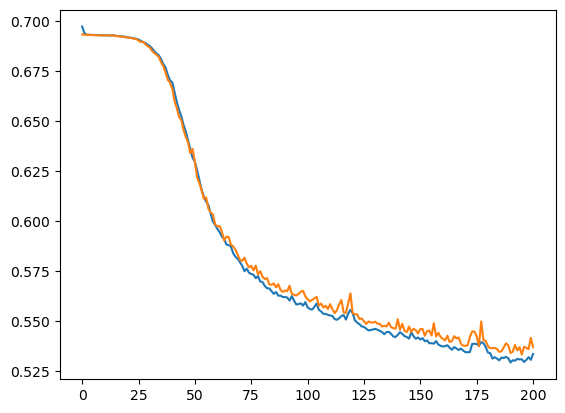

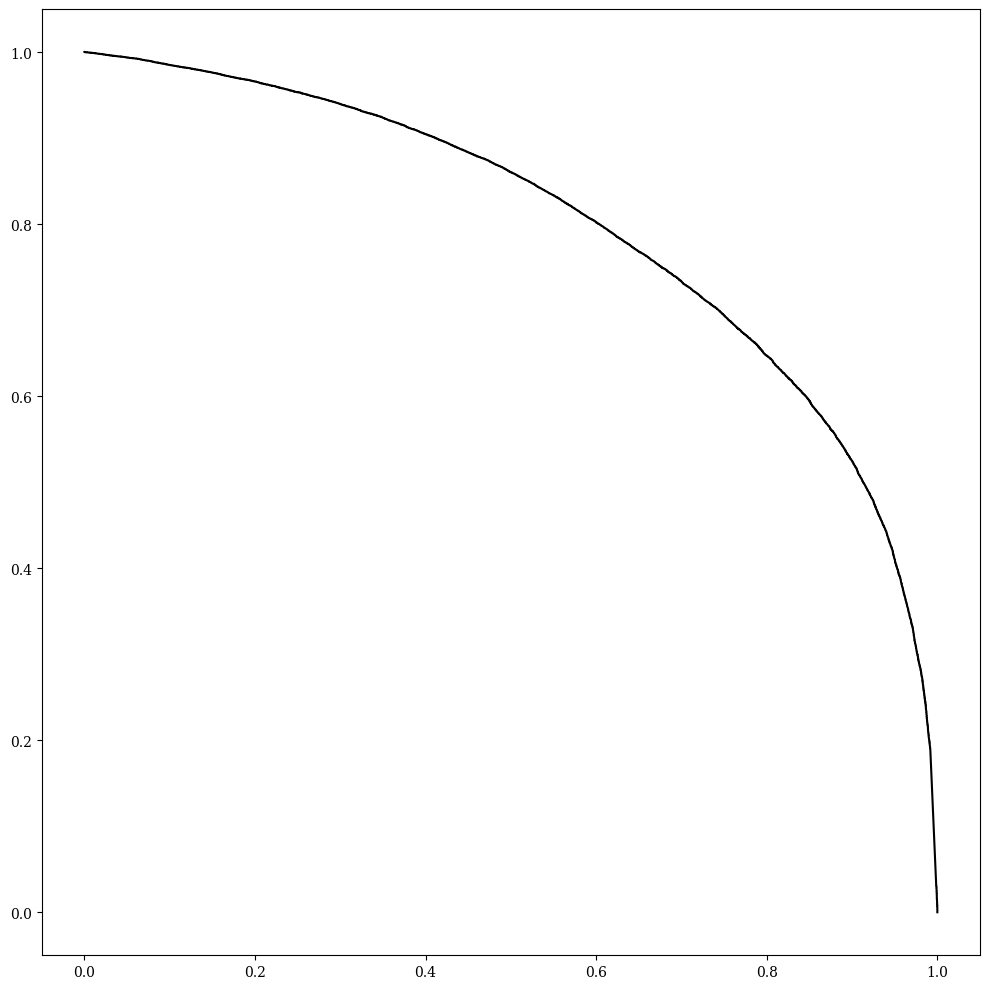

In [6]:
# EFN
Phi_sizes = (60,60,60)
F_sizes = (80,80,80)
lossfn = nn.BCELoss(reduction='mean')
model = EFN(2,1,Phi_sizes,F_sizes).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr=1e-3,eps=1e-07)

n_epoch = 1000
patience = 10
min_loss = 99999
losses = []
val_losses = []
patience_count = 0
for i in range(n_epoch):
    if patience_count == patience:
        break
    epoch_losses = []
    model.train(True)
    for datum in loader:
        Xin,Yin = datum
        optimizer.zero_grad()
        loss = lossfn(model(Xin),Yin)
        epoch_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    model.train(False)
    with torch.no_grad():
        val_loss = lossfn(model(Xval),Yval).detach().cpu().numpy()
    ep_loss = np.mean(epoch_losses)
    losses.append(np.mean(epoch_losses))
    val_losses.append(val_loss)
    if ep_loss < min_loss:
        min_loss = ep_loss
        torch.save(model,"EFN.pt")
        patience_count = 0
    else:
        patience_count += 1
    print("Epoch {0}, Train loss {1:.5f}, Val Loss {2:.5f}".format(i,np.mean(epoch_losses),val_loss))

del model
torch.cuda.empty_cache()
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(losses)),val_losses)

model = torch.load("EFN.pt").to(device)
preds = model(Xtest).detach().cpu().numpy()
pfn_fp, pfn_tp, threshs = roc_curve(Ytest[:,0].to('cpu'), preds[:,0])
auc = roc_auc_score(Ytest.to('cpu'), preds[:,0])
print('AUC:', auc)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

plt.figure(figsize=(10,10))
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='EFN')
    
del preds, model
torch.cuda.empty_cache()

Epoch 0, Train loss 0.69329, Val Loss 0.69321
Epoch 1, Train loss 0.69315, Val Loss 0.69312
Epoch 2, Train loss 0.69313, Val Loss 0.69312
Epoch 3, Train loss 0.69313, Val Loss 0.69310
Epoch 4, Train loss 0.69310, Val Loss 0.69310
Epoch 5, Train loss 0.69312, Val Loss 0.69309
Epoch 6, Train loss 0.69315, Val Loss 0.69309
Epoch 7, Train loss 0.69317, Val Loss 0.69311
Epoch 8, Train loss 0.69323, Val Loss 0.69313
Epoch 9, Train loss 0.69315, Val Loss 0.69313
Epoch 10, Train loss 0.69312, Val Loss 0.69313
Epoch 11, Train loss 0.69310, Val Loss 0.69310
Epoch 12, Train loss 0.69308, Val Loss 0.69308
Epoch 13, Train loss 0.69308, Val Loss 0.69308
Epoch 14, Train loss 0.69309, Val Loss 0.69308
Epoch 15, Train loss 0.69309, Val Loss 0.69306
Epoch 16, Train loss 0.69305, Val Loss 0.69305
Epoch 17, Train loss 0.69305, Val Loss 0.69306
Epoch 18, Train loss 0.69304, Val Loss 0.69305
Epoch 19, Train loss 0.69309, Val Loss 0.69302
Epoch 20, Train loss 0.69307, Val Loss 0.69301
Epoch 21, Train loss 0.

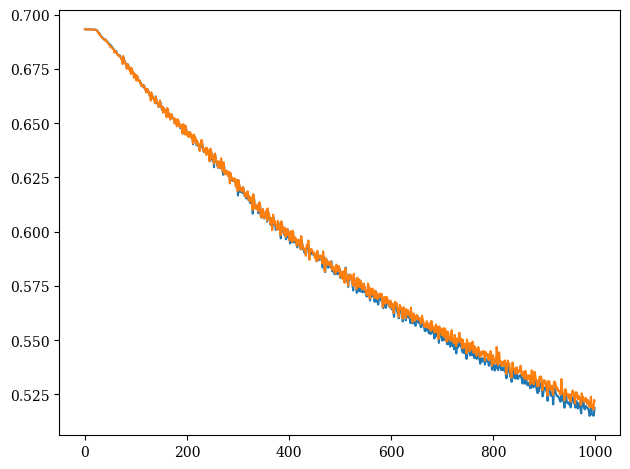

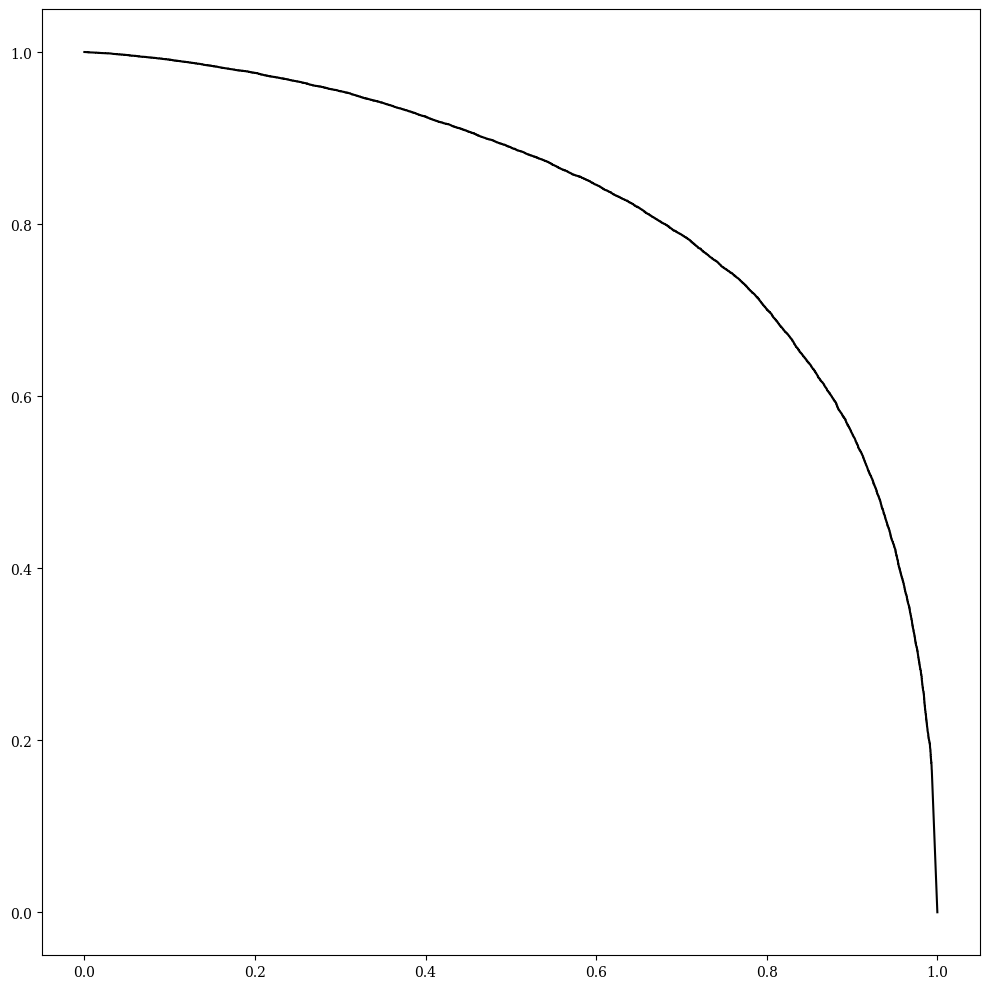

In [17]:
# Spectral EFN
Phi_sizes = (60,60,60)
F_sizes = (80,80,80)
lossfn = nn.BCELoss(reduction='mean')
model = EFN(2,1,Phi_sizes,F_sizes,spectral=True).to(device)
model.apply(init_weights)

n_epoch = 10000
gam1 = 1e-3
gam2 = 1e-5
optimizer = optim.Adam(model.parameters(),lr=gam1,eps=1e-07)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer,(gam2/gam1)**(1/n_epoch))
bs = 10000
dataset = TensorDataset(Xtrain,Ytrain)
loader = DataLoader(dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device='cpu'))

losses = []
val_losses = []
for i in range(n_epoch):
    epoch_losses = []
    model.train(True)
    for datum in loader:
        Xin,Yin = datum
        optimizer.zero_grad()
        loss = lossfn(model(Xin),Yin)
        epoch_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    model.train(False)
    val_loss = lossfn(model(Xval),Yval).detach().cpu().numpy()
    losses.append(np.mean(epoch_losses))
    val_losses.append(val_loss)
    print("Epoch {0}, Train loss {1:.5f}, Val Loss {2:.5f}".format(i,np.mean(epoch_losses),val_loss))
    #scheduler.step()
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(losses)),val_losses)

model.train(False)
preds = model(Xtest).detach().cpu().numpy()
pfn_fp, pfn_tp, threshs = roc_curve(Ytest[:,0].to('cpu'), preds[:,0])
auc = roc_auc_score(Ytest.to('cpu'), preds[:,0])
print('Test AUC:', auc)
print("Test Loss:",lossfn(preds,Ytest)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

plt.figure(figsize=(10,10))
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='EFN')
    
del preds
torch.cuda.empty_cache()

In [37]:
mod = model.to('cpu')

In [57]:
mod.F.transform[0]

Linear(in_features=60, out_features=80, bias=True)

In [60]:
a = mod.F.transform[0]

In [68]:
torch.svd(a.weight)

torch.return_types.svd(
U=tensor([[ 0.0387, -0.2792, -0.1507,  ..., -0.0353,  0.0848, -0.1019],
        [-0.0083, -0.0220,  0.0089,  ...,  0.0050, -0.0542, -0.1339],
        [ 0.2021, -0.1410, -0.1158,  ...,  0.0665, -0.1054,  0.0703],
        ...,
        [-0.0126, -0.0184, -0.0367,  ...,  0.0724,  0.1499,  0.1115],
        [ 0.0330,  0.0447, -0.0453,  ...,  0.1189, -0.0705, -0.1276],
        [-0.0859, -0.0462,  0.0801,  ...,  0.0191,  0.0836,  0.0656]],
       device='cuda:0', grad_fn=<SvdBackward>),
S=tensor([1.0518, 1.0176, 0.9915, 0.9804, 0.9492, 0.9435, 0.9417, 0.9156, 0.9093,
        0.8991, 0.8852, 0.8778, 0.8579, 0.8564, 0.6564, 0.5806, 0.5144, 0.4461,
        0.4128, 0.3802, 0.3643, 0.3625, 0.3393, 0.3156, 0.2972, 0.2884, 0.2795,
        0.2588, 0.2444, 0.2381, 0.2353, 0.2276, 0.2178, 0.2084, 0.2057, 0.1995,
        0.1951, 0.1818, 0.1746, 0.1705, 0.1690, 0.1565, 0.1519, 0.1444, 0.1413,
        0.1350, 0.1237, 0.1171, 0.1163, 0.1033, 0.0978, 0.0934, 0.0914, 0.0869,
        0.

Epoch 0, Train loss 1.71254, Val Loss 0.49129
Epoch 1, Train loss 0.40552, Val Loss 0.25669
Epoch 2, Train loss 0.21491, Val Loss 0.18304
Epoch 3, Train loss 0.17909, Val Loss 0.16402
Epoch 4, Train loss 0.15684, Val Loss 0.14821
Epoch 5, Train loss 0.14164, Val Loss 0.13585
Epoch 6, Train loss 0.13335, Val Loss 0.13038
Epoch 7, Train loss 0.12833, Val Loss 0.12712
Epoch 8, Train loss 0.12739, Val Loss 0.12373
Epoch 9, Train loss 0.12734, Val Loss 0.12170
Epoch 10, Train loss 0.12414, Val Loss 0.11830
Epoch 11, Train loss 0.11470, Val Loss 0.11516
Epoch 12, Train loss 0.11260, Val Loss 0.11561
Epoch 13, Train loss 0.11257, Val Loss 0.12013
Epoch 14, Train loss 0.11220, Val Loss 0.11369
Epoch 15, Train loss 0.11008, Val Loss 0.11410
Epoch 16, Train loss 0.11500, Val Loss 0.11058
Epoch 17, Train loss 0.10775, Val Loss 0.10419
Epoch 18, Train loss 0.10583, Val Loss 0.10390
Epoch 19, Train loss 0.10322, Val Loss 0.10161
Epoch 20, Train loss 0.10163, Val Loss 0.10157
Epoch 21, Train loss 0.

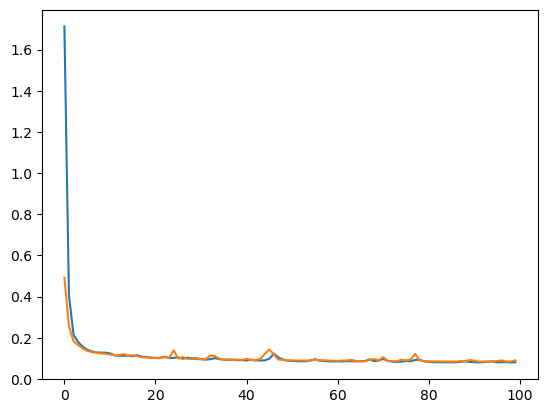

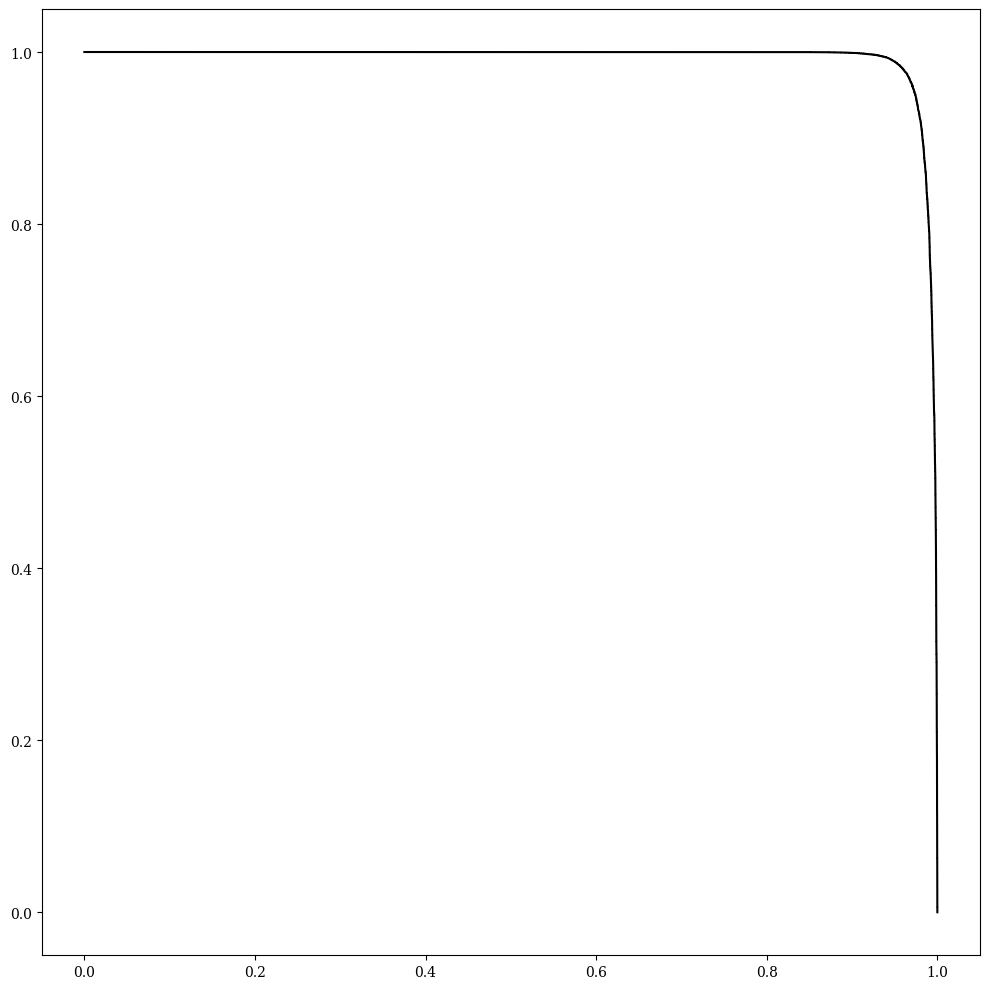

In [5]:
# PFN
Phi_sizes = (60,60,60)
F_sizes = (80,80,80)
lossfn = nn.BCELoss(reduction='mean')
model = PFN(3,1,Phi_sizes,F_sizes).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr=1e-2,eps=1e-07)
bs = 10000
dataset = TensorDataset(Xtrain,Ytrain)
loader = DataLoader(dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device='cpu'))

n_epoch = 100
losses = []
val_losses = []
for i in range(n_epoch):
    epoch_losses = []
    model.train(True)
    for datum in loader:
        Xin,Yin = datum
        optimizer.zero_grad()
        loss = lossfn(model(Xin),Yin)
        epoch_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    model.train(False)
    val_loss = lossfn(model(Xval),Yval).detach().cpu().numpy()
    losses.append(np.mean(epoch_losses))
    val_losses.append(val_loss)
    print("Epoch {0}, Train loss {1:.5f}, Val Loss {2:.5f}".format(i,np.mean(epoch_losses),val_loss))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(losses)),val_losses)

model.train(False)
preds = model(Xtest).detach().cpu().numpy()
pfn_fp, pfn_tp, threshs = roc_curve(Ytest[:,0].to('cpu'), preds[:,0])
auc = roc_auc_score(Ytest.to('cpu'), preds[:,0])
print('AUC:', auc)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

plt.figure(figsize=(10,10))
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
    
del preds
torch.cuda.empty_cache()

Epoch 0, Train loss 0.72437, Val Loss 0.54247
Epoch 1, Train loss 0.49185, Val Loss 0.43437
Epoch 2, Train loss 0.36955, Val Loss 0.29504
Epoch 3, Train loss 0.23888, Val Loss 0.18422
Epoch 4, Train loss 0.17592, Val Loss 0.16748
Epoch 5, Train loss 0.16327, Val Loss 0.15927
Epoch 6, Train loss 0.15583, Val Loss 0.14714
Epoch 7, Train loss 0.14436, Val Loss 0.14069
Epoch 8, Train loss 0.13577, Val Loss 0.13228
Epoch 9, Train loss 0.13124, Val Loss 0.12614
Epoch 10, Train loss 0.12809, Val Loss 0.12214
Epoch 11, Train loss 0.11988, Val Loss 0.11827
Epoch 12, Train loss 0.11736, Val Loss 0.11509
Epoch 13, Train loss 0.11552, Val Loss 0.11471
Epoch 14, Train loss 0.11231, Val Loss 0.11001
Epoch 15, Train loss 0.10993, Val Loss 0.11559
Epoch 16, Train loss 0.11268, Val Loss 0.10840
Epoch 17, Train loss 0.12886, Val Loss 0.14402
Epoch 18, Train loss 0.12167, Val Loss 0.10668
Epoch 19, Train loss 0.11310, Val Loss 0.10616
Epoch 20, Train loss 0.10831, Val Loss 0.10502
Epoch 21, Train loss 0.

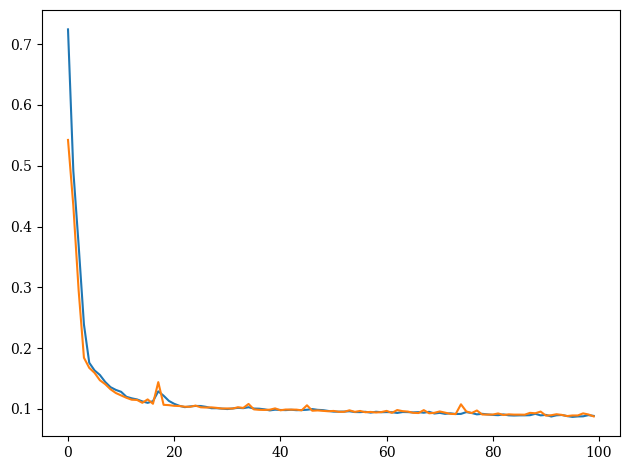

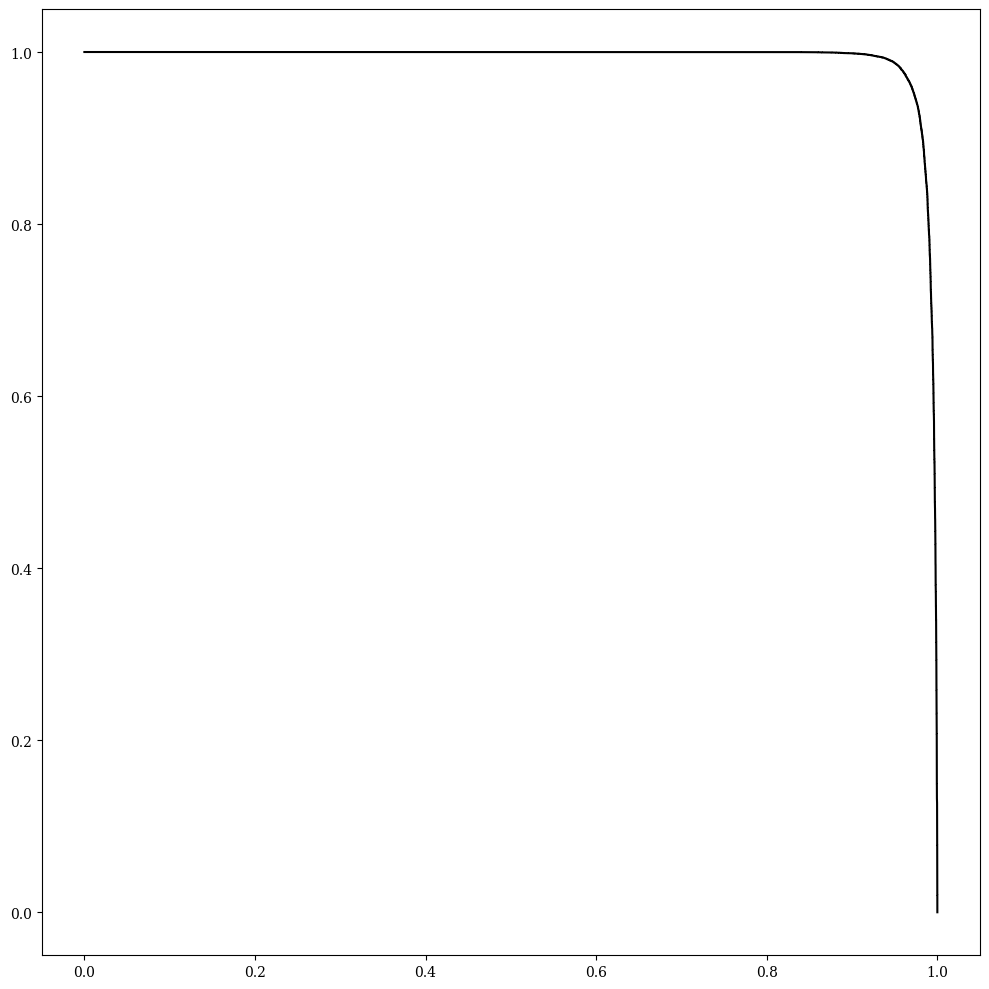

In [7]:
# Spectral PFN
Phi_sizes = (60,60,60)
F_sizes = (80,80,80)
lossfn = nn.BCELoss(reduction='mean')
model = PFN(3,1,Phi_sizes,F_sizes,spectral=True).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(),lr=1e-2,eps=1e-07)
bs = 10000
dataset = TensorDataset(Xtrain,Ytrain)
loader = DataLoader(dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device='cpu'))

n_epoch = 100
losses = []
val_losses = []
for i in range(n_epoch):
    epoch_losses = []
    model.train(True)
    for datum in loader:
        Xin,Yin = datum
        optimizer.zero_grad()
        loss = lossfn(model(Xin),Yin)
        epoch_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    model.train(False)
    val_loss = lossfn(model(Xval),Yval).detach().cpu().numpy()
    losses.append(np.mean(epoch_losses))
    val_losses.append(val_loss)
    print("Epoch {0}, Train loss {1:.5f}, Val Loss {2:.5f}".format(i,np.mean(epoch_losses),val_loss))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(losses)),val_losses)

model.train(False)
preds = model(Xtest).detach().cpu().numpy()
pfn_fp, pfn_tp, threshs = roc_curve(Ytest[:,0].to('cpu'), preds[:,0])
auc = roc_auc_score(Ytest.to('cpu'), preds[:,0])
print('AUC:', auc)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

plt.figure(figsize=(10,10))
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
    
del preds
torch.cuda.empty_cache()